In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
import pickle as pkl
from scipy.ndimage import uniform_filter1d
from matplotlib import pyplot
from matplotlib.colors import LogNorm
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics import si

from PySDM_examples.Ming_et_al_2005.aerosol import CONSTANTS_MING, AerosolMingSM, AerosolMingTM
from PySDM_examples.Ming_et_al_2005.run_Ming_parcel import run_parcel

from PySDM.initialisation.sampling.spectral_sampling import Logarithmic
from PySDM_examples.Ming_et_al_2005.parameterization import solve_smax, droplet_number_conc

In [3]:
# create aerosol according to Table 1
formulae = Formulae(constants=CONSTANTS_MING)
const = formulae.constants
nu = const.Mv / const.rho_w

SM1 = AerosolMingSM(water_molar_volume=nu, N=200 / si.cm**3, D=0.02 * si.um, sig=2.5)
SM2 = AerosolMingSM(water_molar_volume=nu, N=1000 / si.cm**3, D=0.02 * si.um, sig=2.5)
SM3 = AerosolMingSM(water_molar_volume=nu, N=1000 / si.cm**3, D=0.02 * si.um, sig=1.5)
SM4 = AerosolMingSM(water_molar_volume=nu, N=200 / si.cm**3, D=0.2 * si.um, sig=2.5)
SM5 = AerosolMingSM(water_molar_volume=nu, N=10000 / si.cm**3, D=0.02 * si.um, sig=2.5)

TM1M = AerosolMingTM(water_molar_volume=nu, N1=340 / si.cm**3, D1=0.01 * si.um, sig1=1.6,
                                            N2=60 / si.cm**3, D2=0.07 * si.um, sig2=2.0,
                                            N3=3.1 / si.cm**3, D3=0.62 * si.um, sig3=2.7)
TM2M = AerosolMingTM(water_molar_volume=nu, N1=680 / si.cm**3, D1=0.01 * si.um, sig1=1.6,
                                            N2=120 / si.cm**3, D2=0.07 * si.um, sig2=2.0,
                                            N3=6.2 / si.cm**3, D3=0.62 * si.um, sig3=2.7)
TM1C = AerosolMingTM(water_molar_volume=nu, N1=1000 / si.cm**3, D1=0.016 * si.um, sig1=1.6,
                                            N2=800 / si.cm**3, D2=0.068 * si.um, sig2=2.1,
                                            N3=0.72 / si.cm**3, D3=0.92 * si.um, sig3=2.2)
TM2C = AerosolMingTM(water_molar_volume=nu, N1=2000 / si.cm**3, D1=0.016 * si.um, sig1=1.6,
                                            N2=1600 / si.cm**3, D2=0.068 * si.um, sig2=2.1,
                                            N3=1.44 / si.cm**3, D3=0.92 * si.um, sig3=2.2)
TM1B = AerosolMingTM(water_molar_volume=nu, N1=6400 / si.cm**3, D1=0.016 * si.um, sig1=1.7,
                                            N2=2300 / si.cm**3, D2=0.076 * si.um, sig2=2.0,
                                            N3=3.2 / si.cm**3, D3=1.02 * si.um, sig3=2.16)
TM2B = AerosolMingTM(water_molar_volume=nu, N1=12800 / si.cm**3, D1=0.016 * si.um, sig1=1.7,
                                            N2=4600 / si.cm**3, D2=0.076 * si.um, sig2=2.0,
                                            N3=6.4 / si.cm**3, D3=1.02 * si.um, sig3=2.16)
TM1U = AerosolMingTM(water_molar_volume=nu, N1=106000 / si.cm**3, D1=0.014 * si.um, sig1=1.8,
                                            N2=32000 / si.cm**3, D2=0.054 * si.um, sig2=2.16,
                                            N3=5.4 / si.cm**3, D3=0.86 * si.um, sig3=2.21)
TM2U = AerosolMingTM(water_molar_volume=nu, N1=212000 / si.cm**3, D1=0.014 * si.um, sig1=1.8,
                                            N2=64000 / si.cm**3, D2=0.054 * si.um, sig2=2.16,
                                            N3=10.8 / si.cm**3, D3=0.86 * si.um, sig3=2.21)

aerosol_dict = {"SM1":SM1, "SM2":SM2, "SM3":SM3, "SM4":SM4, "SM5":SM5,
                "TM1M":TM1M, "TM2M":TM2M, "TM1C":TM1C, "TM2C":TM2C, 
                "TM1B":TM1B, "TM2B":TM2B, "TM1U":TM1U, "TM2U":TM2U,}

In [4]:
n_sd_per_mode = 20

T_init = 283
p_init = 800e2
w_list = np.array([0.03, 0.1, 0.5, 1.0, 5.0, 10.0]) * si.m / si.s

In [5]:
restore = True

if restore:
    with open(f"data_pysdm_parcel.pkl",'rb') as file:
        output = pkl.load(file)
else:
    output = {}

    for aerosol_name, ai in aerosol_dict.items():
        Nd_S_list = []
        Nd_V_list = []
        AF_S_list = []
        AF_V_list = []
        Smax_list = []
        for wi in w_list:
            print(wi, aerosol_name)
            result = run_parcel(formulae, wi, ai, n_sd_per_mode, 
                RH0=0.998, T0=T_init * si.K, p0=p_init * si.Pa, z_max=200 * si.m, dz=10 * si.m)
            Nd_S_list.append(result.Nd_S)
            Nd_V_list.append(result.Nd_V)
            AF_S_list.append(result.activated_fraction_S)
            AF_V_list.append(result.activated_fraction_V)
            Smax_list.append(np.nanmax(np.array(result.profile["smax"])))
        output[aerosol_name] = {"Nd_S":Nd_S_list, "Nd_V":Nd_V_list, "AF_S":AF_S_list, "AF_V":AF_V_list, "Smax":Smax_list}
    
    with open(f"data_pysdm_parcel.pkl",'wb') as file:
        pkl.dump(output, file)

In [6]:
param_output = {}

for aerosol_name, ai in aerosol_dict.items():
    Rj, Nj = [], []
    for m in ai.modes:
        rj, nj = Logarithmic(m['spectrum']).sample(100)
        Rj.append(rj)
        Nj.append(nj)
    Rj = np.concatenate(Rj, axis=0)
    Nj = np.concatenate(Nj, axis=0)

    Nd_list = []
    AF_list = []
    Smax_list = []
    for wi in w_list:
        smax = solve_smax(wi, T_init, p_init, Rj, Nj)
        Nd = droplet_number_conc(Rj, Nj, smax, T_init) # m-3
        AF = Nd / np.sum(Nj)
        Smax_list.append(smax)
        Nd_list.append(Nd / 1e6) # cm-3
        AF_list.append(AF)
    
    param_output[aerosol_name] = {"Nd":Nd_list, "AF":AF_list, "Smax":Smax_list}

/Users/claresinger/Research/PySDM/examples/PySDM_examples/Ming_et_al_2005/parameterization.py:89: RuntimeWarning: invalid value encountered in double_scalars
  return (


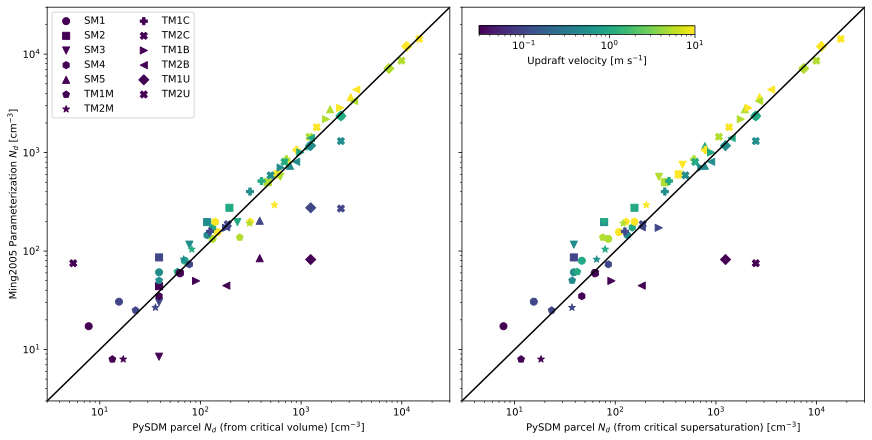

HTML(value="<a href='./Fig1.pdf' target='_blank'>./Fig1.pdf</a><br>")

In [7]:
marker = {"SM1":"o", "SM2":"s", "SM3":"v", "SM4":"h", "SM5":"^",
          "TM1M":"p", "TM2M":"*", "TM1C":"P", "TM2C":"X", 
          "TM1B":">", "TM2B":"<", "TM1U":"D", "TM2U":"X",}

fig,axes = pyplot.subplots(1,2,figsize=(12,6), sharex=True, sharey=True, constrained_layout=True)

ax = axes[0]
for aerosol_name in aerosol_dict.keys():
    p = ax.scatter(output[aerosol_name]["Nd_V"], param_output[aerosol_name]["Nd"], s=50,
        c=w_list, marker=marker[aerosol_name], cmap="viridis", norm=LogNorm(), label=aerosol_name)
ax.legend(ncol=2)
ax.plot([1,1e5],[1,1e5],"k-")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(3,3e4)
ax.set_ylim(3,3e4)
ax.set_xlabel("PySDM parcel $N_d$ (from critical volume) [cm$^{-3}$]")
ax.set_ylabel("Ming2005 Parameterization $N_d$ [cm$^{-3}$]")

ax = axes[1]
for aerosol_name in aerosol_dict.keys():
    p = ax.scatter(output[aerosol_name]["Nd_S"], param_output[aerosol_name]["Nd"], s=50,
        c=w_list, marker=marker[aerosol_name], cmap="viridis", norm=LogNorm(), label=aerosol_name)
cax = fig.add_axes([0.55, 0.93, 0.25, 0.02])
pyplot.colorbar(p, cax=cax, orientation="horizontal", label="Updraft velocity [m s$^{-1}$]")
ax.plot([1,1e5],[1,1e5],"k-")
ax.set_xlabel("PySDM parcel $N_d$ (from critical supersaturation) [cm$^{-3}$]")

show_plot("Fig1.pdf")